# Gradient Descent (경사하강법)

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("텐서플로 버전: {}".format(tf.__version__))
print("즉시 실행: {}".format(tf.executing_eagerly()))
np.set_printoptions(precision=4, linewidth=500)

텐서플로 버전: 2.0.0-rc0
즉시 실행: True


## 측정된 꽃받침과 꽃잎의 길이와 폭을 토대로 붓꽃을 분류하는 모델을 통해 경사하강법(GD) 학습
* Iris setosa
* Iris virginica
* Iris versicolor

![꽃](https://www.tensorflow.org/images/iris_three_species.jpg)

## 데이터 (CSV)

In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
print("데이터셋이 복사된 위치: {}".format(train_dataset_fp))
!head -n5 {train_dataset_fp}

데이터셋이 복사된 위치: /home/woong/.keras/datasets/iris_training.csv
120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [3]:
# column_name = ['꽃잎 길이', '꽃잎 너비', '꽃받침 길이', '꽃받침 너비', '종']
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

# species = 0: Iris setosa, 1: Iris versicolor, 2: Iris virginica
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("특성: {}".format(feature_names))
print("레이블: {}".format(label_name))

특성: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
레이블: species


In [4]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

train_dataset

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


<PrefetchDataset shapes: (OrderedDict([(sepal_length, (None,)), (sepal_width, (None,)), (petal_length, (None,)), (petal_width, (None,))]), (None,)), types: (OrderedDict([(sepal_length, tf.float32), (sepal_width, tf.float32), (petal_length, tf.float32), (petal_width, tf.float32)]), tf.int32)>

In [5]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=array([5.9, 5.4, 5.7, 4.8, 5.4, 5.3, 5. , 5. , 6.5, 5.4, 6.7, 7.7, 5.1, 6.8, 6.7, 6. , 5.2, 5.8, 4.7, 7.7, 5.7, 6.4, 5. , 6.4, 5.9, 7.7, 5.1, 6.4, 4.9, 6. , 6.2, 4.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=70, shape=(32,), dtype=float32, numpy=array([3.2, 3.9, 4.4, 3.1, 3. , 3.7, 3. , 3.6, 2.8, 3.9, 3. , 3.8, 3.7, 3.2, 3.1, 3. , 3.4, 2.7, 3.2, 3. , 2.8, 2.7, 3.4, 2.8, 3. , 2.8, 3.8, 3.2, 3.1, 2.2, 2.2, 3.2], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=array([4.8, 1.3, 1.5, 1.6, 4.5, 1.5, 1.6, 1.4, 4.6, 1.7, 5.2, 6.7, 1.5, 5.9, 5.6, 4.8, 1.4, 5.1, 1.3, 6.1, 4.1, 5.3, 1.6, 5.6, 5.1, 6.7, 1.9, 5.3, 1.5, 5. , 4.5, 1.6], dtype=float32)>),
             ('petal_width',
              <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=array([1.8, 0.4, 0.4, 0.2, 1.5, 0.2, 0.2, 0.2, 1.5, 0.4,

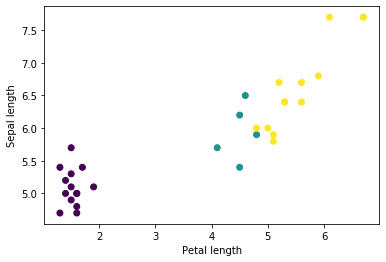

In [6]:
plt.scatter(features['petal_length'], features['sepal_length'], c=labels, cmap='viridis')
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [7]:
def pack_features_vector(features, labels):
  """특성들을 단일 배열로 묶습니다."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [8]:
train_dataset = train_dataset.map(pack_features_vector)

In [9]:
train_dataset

<MapDataset shapes: ((None, 4), (None,)), types: (tf.float32, tf.int32)>

In [13]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.6 2.9 4.6 1.3]
 [5.4 3.9 1.3 0.4]
 [4.6 3.6 1.  0.2]
 [4.9 2.4 3.3 1. ]
 [5.8 2.7 5.1 1.9]], shape=(5, 4), dtype=float32)


## 데이터 (pandas)

In [10]:
# pandas.read_csv : Read a comma-separated values (csv) file into DataFrame.
pdFeature = pd.read_csv(train_dataset_fp, sep=',', skiprows=1, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])

# pandas.DataFrame.pop : Return item and drop from frame. Raise KeyError if not found.
pdLabel = pdFeature.pop('species')

# pandas.DataFrame.head : Return the first n rows.
pdFeature.head(4)

,sepal_length,sepal_width,petal_length,petal_width
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1


In [11]:
pdDataset = tf.data.Dataset.from_tensor_slices((pdFeature.values, pdLabel.values))

In [12]:
for feat, spec in pdDataset.take(5):
  print ('Features: {}, Species: {}'.format(feat, spec))

Features: [6.4 2.8 5.6 2.2], Species: 2
Features: [5.  2.3 3.3 1. ], Species: 1
Features: [4.9 2.5 4.5 1.7], Species: 2
Features: [4.9 3.1 1.5 0.1], Species: 0
Features: [5.7 3.8 1.7 0.3], Species: 0
